# building Control chart and benchamrking with strucutral change

In [1]:
# === Import Libraries ===
import sqlite3
import numpy as np
import comet_ml
from config import settings, create_psd_path
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd 
from tqdm import tqdm
from torch.utils.data import DataLoader

In [2]:
# Use LaTeX-quality fonts in the plot
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

# === Load Settings and Initialize Paths ===
settings_proc = 'SETTINGS1'
settings_simu = 'SETTINGS1'
root = Path(settings.data.path["processed"])
database_path = create_psd_path(root,settings_proc,settings_simu)

# === Fetch Metadata ===
from psm.utils.data.metadata import get_metadata_processed
metadata = get_metadata_processed(settings_proc, settings_simu)
freq_axis = metadata['freq']


In [3]:
# === Model Loading Paths and Initialization ===
name_model_1 = 'best-epoch=28-val_loss=2.13.ckpt'
name_model_2 = 'best-epoch=95-val_loss=3.57.ckpt'
model_paths = Path(settings.data.path['model']) / 'model'
model_path_1 = model_paths / name_model_1
model_path_2 = model_paths / name_model_2
from psm.models.vanilla_classification import DenseSignalClassifierModule
model_1 = DenseSignalClassifierModule.load_from_checkpoint(model_path_1)
model_2 = DenseSignalClassifierModule.load_from_checkpoint(model_path_2)

In [4]:
# === Anomaly Detection Setup ===
from psm.models.ad_systems import AD_GMM
ad_gmm_1 = AD_GMM(num_classes=20, model=model_1.model)
ad_gmm_2 = AD_GMM(num_classes=20, model=model_2.model)


In [5]:
# === Create Dataloader ===
from psm.models.prepare_data import CreateTransformer, PSDDataModule, PSDDataset, PSDDataset_test

transformer = CreateTransformer(database_path, freq=freq_axis, freq_min=0, freq_max=150)
transform_psd = transformer.transform_psd
transform_label = transformer.transform_label
dm = PSDDataModule(database_path, transform_psd, transform_label, batch_size=32)
dm.setup()
train_dl = dm.train_dataloader()
ad_gmm_1.fit(train_dl)
ad_gmm_2.fit(train_dl)

(anomaly_level=?) AND stage=? (0, 'train')
(anomaly_level=?) AND stage=? (0, 'test')


In [97]:
psd_test = PSDDataset_test(database_path=database_path, transform=transform_psd, transform_label=transform_label)


system_name=? ('*',)


# model testing

In [98]:
psd_dl = DataLoader(psd_test, batch_size=10000)

lists = {
    'system_name': [],
    'anomaly_index': [],
    'anomaly_level': [],
    'stage': [],
    'excitation': [],
    'latent': []
}

for batch in psd_dl:
    psd, system_name, anomaly_level, stage, excitation_amplitude, latent_value = batch
    anomaly_index = ad_gmm_1.predict(psd)

    for key, value in zip(lists.keys(), [system_name, anomaly_index, anomaly_level, stage, excitation_amplitude, latent_value]):
        if isinstance(value, tuple):
            lists[key].extend(list(value))
        else:
            lists[key].extend(value.tolist())
df_res = pd.DataFrame(lists)

/tmp/ipykernel_160708/3927764946.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res_sys['stage'] = pd.Categorical(df_res_sys['stage'], categories=stage_order, ordered=True)


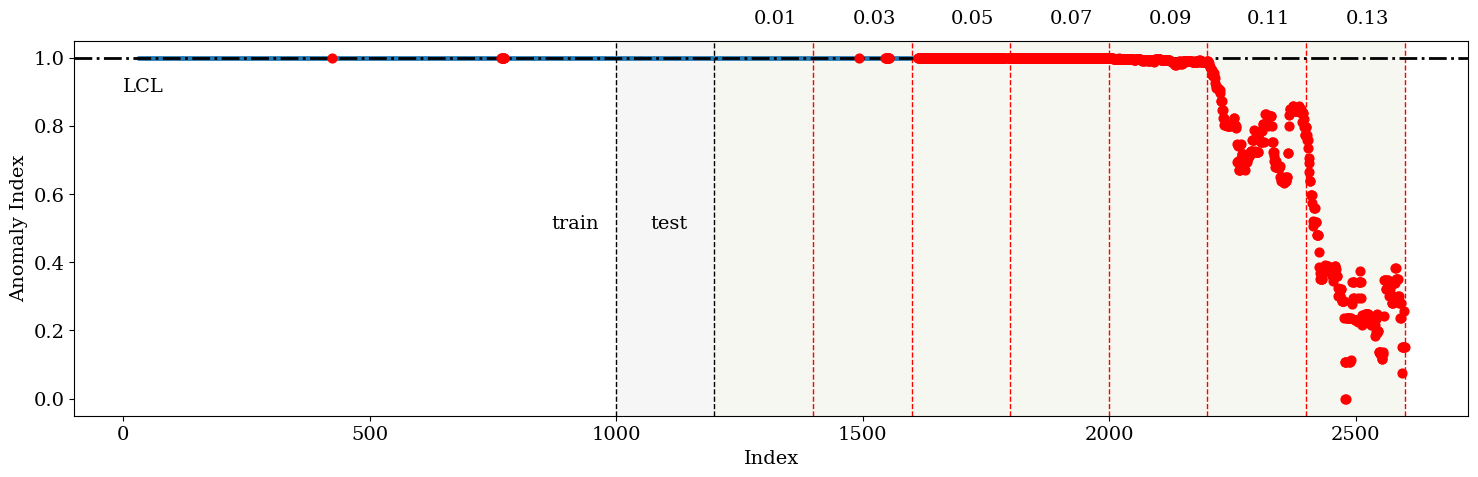

In [108]:
df_res_sys = df_res[df_res['system_name']==3]
stage_order = ['train', 'test', 'anomaly']
df_res_sys['stage'] = pd.Categorical(df_res_sys['stage'], categories=stage_order, ordered=True)

df_res_sys = df_res_sys.sort_values(by=['stage', 'anomaly_level'])
df_res_sys['stage'] = df_res_sys['stage'].astype(str)
#reset the index
df_res_sys = df_res_sys.reset_index(drop=True)
# change index value 
change_stage_indices = df_res_sys[df_res_sys['stage'].shift(-1) != df_res_sys['stage']].index.values[:-1]
change_anomaly_indices = df_res_sys[df_res_sys['anomaly_level'].shift(-1)!=df_res_sys['anomaly_level']].index.values[1:]
dict_stage = dict(zip(change_stage_indices, df_res_sys['stage'].iloc[change_stage_indices]))
dict_anomaly = dict(zip(change_anomaly_indices, df_res_sys['anomaly_level'].iloc[change_anomaly_indices]))


min_max_normalization = lambda x: (x - x.min()) / (x.max() - x.min()) +1
df_res_sys.loc[:, 'anomaly_index'] = min_max_normalization(df_res_sys['anomaly_index'])
df_res_sys.loc[:, 'anomaly_index'] = np.log(df_res_sys['anomaly_index'])
df_res_sys['anomaly_index'] = df_res_sys['anomaly_index'].rolling(30).median()
df_res_sys.loc[:, 'anomaly_index'] = min_max_normalization(df_res_sys['anomaly_index'])-1
std = df_res_sys[df_res_sys['stage'] =='train']['anomaly_index'].std()

std = df_res_sys[df_res_sys['stage'] =='train']['anomaly_index'].std()
mean = df_res_sys[df_res_sys['stage'] =='train']['anomaly_index'].mean()
LCL = mean - 3*std - eps



fig, ax = plt.subplots(figsize=(15, 5))
df_res_sys['anomaly_index'].plot(marker='o', markersize=2, linestyle='', ax=ax, label='anomaly index', alpha=0.7)

# Highlight different stages
colors = ['lightgray', 'lightyellow', 'lightpink']
for idx, color in zip(change_stage_indices, colors):
    ax.axvspan(idx, change_stage_indices[idx+1] if idx+1 < len(change_stage_indices) else df_res_sys.index[-1], facecolor=color, alpha=0.2)

# Change in stage
for k, v in dict_stage.items():
    plt.axvline(x=k, color='k', linestyle='--', linewidth=1)
    plt.text(x=k-130, y=0.5, s=v, rotation=0)

# Anomaly level change
for k, v in dict_anomaly.items():
    plt.axvline(x=k, color='r', linestyle='--', linewidth=1)
    plt.text(x=k-120, y=1.1, s=v, rotation=0)

# LCL
plt.axhline(y=LCL, color='k', linestyle='-.', linewidth=2, label='LCL')
plt.text(x=0, y=LCL-0.1, s='LCL', rotation=0)
below_LCL = df_res_sys['anomaly_index'] < LCL
plt.scatter(df_res_sys[below_LCL].index, df_res_sys[below_LCL]['anomaly_index'], color='red', s=40, marker='o', zorder=2, label='Below LCL')

# Add title and labels
plt.xlabel('Index')
plt.ylabel('Anomaly Index')

plt.tight_layout()
plt.show()


/tmp/ipykernel_156357/260981821.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sys['stage'] = pd.Categorical(df_sys['stage'], categories=stage_order, ordered=True)


UCL:  4.288324209813311


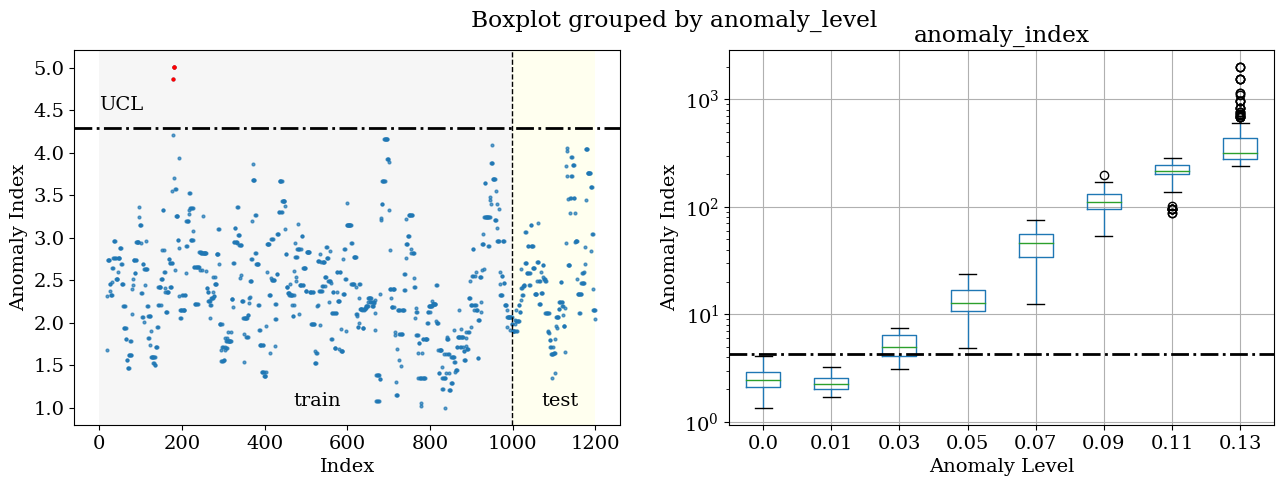

In [ ]:
import sys
eps = sys.float_info.epsilon
def select_system(df, system_name):
    return df[df['system_name'] == system_name]

def order_df(df_sys):
    stage_order = ['train', 'test','anomaly']
    df_sys['stage'] = pd.Categorical(df_sys['stage'], categories=stage_order, ordered=True)
    df_sys = df_sys.sort_values(by=['stage', 'anomaly_level'])
    df_sys['stage']= df_sys['stage'].astype(str)
    df_sys = df_sys.reset_index(drop=True)
    return df_sys

def get_CL(df_sys):
    data_tr = df_sys['anomaly_index'][df_sys['stage']=='train']
    data_tr = data_tr[~data_tr.isna()]
    std = np.std(data_tr)
    mean = np.mean(data_tr)
    UCL = mean + 3*std + eps
    LCL = mean - 3*std - eps
    print('UCL: ', UCL)
    return UCL, LCL

def get_change_indices(df):
    change_stage_indices = df[df['stage'].shift(-1) != df['stage']].index.values[:-1]
    change_anomaly_indices = df[df['anomaly_level'].shift(-1)!=df['anomaly_level']].index.values[1:]
    dict_stage = dict(zip(change_stage_indices, df['stage'].iloc[change_stage_indices]))
    dict_anomaly = dict(zip(change_anomaly_indices, df['anomaly_level'].iloc[change_anomaly_indices]))
    
    return dict_stage, dict_anomaly

def scale_anomaly_index(df_sys):
    df_sys.loc[:,'anomaly_index'] = df_sys['anomaly_index'].rolling(20).median()
    df_sys.loc[:,'anomaly_index'] = -1 * df_sys['anomaly_index']
    # add the min to make it positive
    df_sys.loc[:,'anomaly_index'] = df_sys['anomaly_index'] - df_sys['anomaly_index'].min() + 1
    return df_sys

def get_ax_bounds(ax):
    return ax.get_xlim(), ax.get_ylim()

def get_ax_middle_y(ax):
    min,max= get_ax_bounds(ax)[1]
    return (min+3*max)/4
def get_ax_range_y(ax):
    min,max= get_ax_bounds(ax)[1]
    return max-min
def get_text_loc(ax):
    min,max= get_ax_bounds(ax)[1]
    loc = min + 0.05*(max-min)
    return loc



def plot_control_chart(df,CL):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    colors=['lightgray', 'lightyellow', 'lightred']
    train_test_df = df[df['stage'] != 'anomaly']
    test_anomaly_df = df[df['stage'] != 'train']
    

    # Plot train and test in timeseries fashion
    train_test_df['anomaly_index'].plot(marker='o', markersize=2, linestyle='', ax=axs[0],  alpha=0.7)
    # plot a line where the test start and color the area
    stage_indice,_ = get_change_indices(train_test_df)
    # Highlight different stages
    colors = ['lightgray', 'lightyellow']
    train_end_idx=train_test_df.index[train_test_df['stage']=='train'][-1]
    test_end_idx=train_test_df.index[train_test_df['stage']=='test'][-1]
    axs[0].axvspan(0, train_end_idx, facecolor=colors[0], alpha=0.2)
    axs[0].axvspan(train_end_idx, test_end_idx, facecolor=colors[1], alpha=0.5)
    # vertical line where the test starts
    axs[0].axvline(x=train_end_idx, color='k', linestyle='--', linewidth=1)
    text_loc = get_text_loc(axs[0])
    mid_test_x = (train_end_idx+test_end_idx)/2
    mid_train_x = (0+train_end_idx)/2

    axs[0].text(x=mid_test_x-30, y=text_loc, s='test', rotation=0)
    axs[0].text(x=mid_train_x-30, y=text_loc, s='train', rotation=0)
    # add UCL
    range_y = get_ax_range_y(axs[0])
    axs[0].axhline(y=CL, color='k', linestyle='-.', linewidth=2, label='UCL')
    axs[0].text(x=0, y=CL+0.05*range_y, s='UCL', rotation=0)
    # color the dots above UCL
    above_UCL = train_test_df['anomaly_index'] > UCL
    axs[0].scatter(train_test_df[above_UCL].index, train_test_df[above_UCL]['anomaly_index'], color='red', s=4, marker='o', zorder=2, label='Above UCL')


    
    get_change_indices(train_test_df)

    axs[0].set_xlabel('Index')
    axs[0].set_ylabel('Anomaly Index')
    
    # plot anomaly with boxplots where are the anomaly levels is the x axis
    test_anomaly_df.boxplot(column='anomaly_index', by='anomaly_level', ax=axs[1])

    axs[1].set_yscale('log')
    axs[1].set_xlabel('Anomaly Level')
    axs[1].set_ylabel('Anomaly Index')
    # add UCL

    range_y = get_ax_range_y(axs[1])
    axs[1].axhline(CL, color='k', linestyle='-.', linewidth=2, label='UCL')
    
df_sys = select_system(df_res, 1)
df_sys = order_df(df_sys)
df_sys = scale_anomaly_index(df_sys)
UCL, LCL = get_CL(df_sys)



plot_control_chart(df_sys,CL=UCL)

    

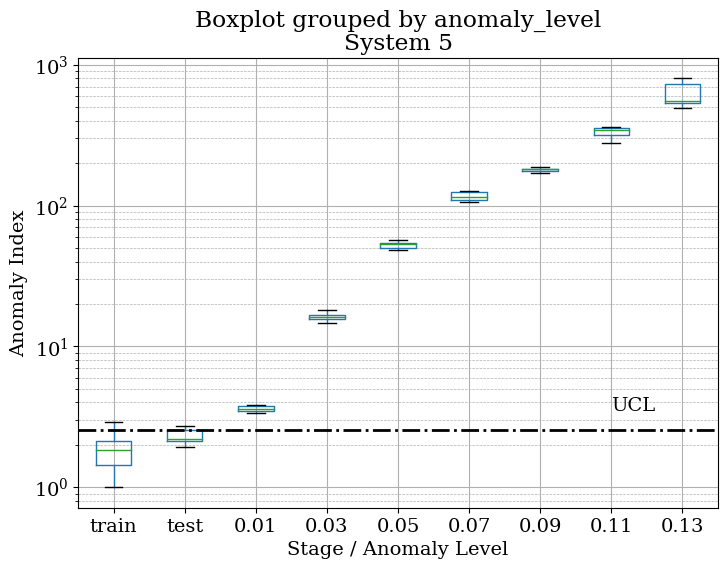

In [119]:
import sys
import matplotlib.pyplot as plt
import pandas as pd
from psm.eval.aucs_computation import compute_auc
from functools import partial 

eps = sys.float_info.epsilon
def select_system(df, system_name):
    return df[df['system_name'] == system_name]

def order_df(df_sys):
    stage_order = ['train', 'test','anomaly']
    df_sys.loc[:,'stage'] = pd.Categorical(df_sys['stage'], categories=stage_order, ordered=True)
    df_sys = df_sys.sort_values(by=['stage', 'anomaly_level'])
    df_sys.loc[:,'stage']= df_sys['stage'].astype(str)
    df_sys = df_sys.reset_index(drop=True)
    return df_sys

def get_CL(df_sys):
    data_tr = df_sys['anomaly_index'][df_sys['stage']=='train']
    data_tr = data_tr[~data_tr.isna()]
    UCL = np.quantile(data_tr, 0.95)
    LCL = np.quantile(data_tr, 0.05)
    return UCL, LCL

def get_change_indices(df):
    change_stage_indices = df[df['stage'].shift(-1) != df['stage']].index.values[:-1]
    change_anomaly_indices = df[df['anomaly_level'].shift(-1)!=df['anomaly_level']].index.values[1:]
    dict_stage = dict(zip(change_stage_indices, df['stage'].iloc[change_stage_indices]))
    dict_anomaly = dict(zip(change_anomaly_indices, df['anomaly_level'].iloc[change_anomaly_indices]))
    
    return dict_stage, dict_anomaly

def average_window(df_sys, window=20):
    # Apply rolling median only within each 'stage' and 'anomaly_level' group
    df_sys['anomaly_index'] = df_sys.groupby(['stage', 'anomaly_level'])['anomaly_index'].transform(lambda x: x.rolling(window).median())
    return df_sys


def scale_anomaly_index(df_sys):
    df_sys.loc[:,'anomaly_index'] = -1 * df_sys['anomaly_index']
    # add the min to make it positive
    df_sys.loc[:,'anomaly_index'] = df_sys['anomaly_index'] - df_sys['anomaly_index'].min() + 1
    return df_sys

def get_auc_per_level(df_sys):
    test_data = df_sys['anomaly_index'][df_sys['stage'] == 'test']
    anoumalous_data = df_sys[df_sys['stage'] == 'anomaly']
    compute_auc_partial = partial(compute_auc, healthy=test_data)
    df_grouped = anoumalous_data.groupby(['anomaly_level'])['anomaly_index'].apply(compute_auc_partial)
    df_grouped = df_grouped.reset_index()
    return df_grouped

def plot_boxplot_with_train(df_sys, UCL,system_name:int=None):
    # Add a dummy anomaly level for train data to plot it alongside test data
    train_data = df_sys[df_sys['stage'] == 'train'].copy()
    train_data['anomaly_level'] = 'train'
    combined_df = pd.concat([train_data, df_sys[df_sys['stage'] != 'train']])
    
    # Convert all anomaly levels to strings and rename '0.0' to 'test'
    combined_df['anomaly_level'] = combined_df['anomaly_level'].astype(str)
    combined_df['anomaly_level'] = combined_df['anomaly_level'].replace('0.0', 'test')

    # Sort categories
    categories_order = ['train', 'test'] + sorted([str(x) for x in df_sys['anomaly_level'].unique() if x != 0.0])
    combined_df['anomaly_level'] = pd.Categorical(combined_df['anomaly_level'], categories=categories_order, ordered=True)

    # Boxplot
    fig, ax = plt.subplots(figsize=(8, 6))
    combined_df.boxplot(column='anomaly_index', by='anomaly_level', ax=ax, showfliers=False)
    
    ax.set_yscale('log')
    ax.set_xlabel('Stage / Anomaly Level')
    ax.set_ylabel('Anomaly Index')
    
    # Add UCL
    ax.axhline(UCL, color='k', linestyle='-.', linewidth=2, label='UCL')
    ax.text(8, UCL *1.5, 'UCL', rotation=0, va='center')
    if system_name:
        ax.set_title(f'System {system_name}')
    
    ax.grid(True, axis='y', which='minor', linestyle='--', linewidth=0.5)
    plt.close(fig)
    return ax
    # suppress title of boxplot that is automatically generated




df_sys = select_system(df_res, 5)
df_sys = order_df(df_sys)
df_sys = average_window(df_sys,window=100)
df_sys_n = scale_anomaly_index(df_sys)
UCL, LCL = get_CL(df_sys_n)

ax = plot_boxplot_with_train(df_sys_n, UCL,system_name=5)

fig = ax.get_figure()
fig

In [81]:
def compute_anomaly_index(psd_dl):
    lists = {
        'system_name': [],
        'anomaly_index': [],
        'anomaly_level': [],
        'stage': [],
        'excitation': [],
        'latent': []
    }

    for batch in psd_dl:
        psd, system_name, anomaly_level, stage, excitation_amplitude, latent_value = batch
        anomaly_index = ad_gmm_1.predict(psd)

        for key, value in zip(lists.keys(), [system_name, anomaly_index, anomaly_level, stage, excitation_amplitude, latent_value]):
            if isinstance(value, tuple):
                lists[key].extend(list(value))
            else:
                lists[key].extend(value.tolist())
    df_res = pd.DataFrame(lists)
    return df_res

In [112]:
# summuarize the function above in one class 
from psm.models.ad_systems import AD_system
from typing import Union
from torch.utils.data import DataLoader, Dataset
from dataclasses import dataclass
from collections import defaultdict
def nested_dict():
    return defaultdict(nested_dict)

@dataclass
class Benchmark_SA:
    ad_system : AD_system
    dl : Union[Dataset,DataLoader]
    batch_size:int

    def __post_init__(self):
        if isinstance(self.dl,Dataset):
            self.dl = DataLoader(self.dl, batch_size=self.batch_size, shuffle=False)

        
        self.df_res = self.Compute_anomaly_index()
        
    def Compute_anomaly_index(self):
        return compute_anomaly_index(self.dl)
    
    def evaluate_one_system(self,system_name:int, window:int=None):
        df_sys = select_system(self.df_res, system_name)
        df_sys = order_df(df_sys)
        df_sys = scale_anomaly_index(df_sys)
        auc = get_auc_per_level(df_sys)
        if window is not None:
            df_sys = average_window(df_sys,window=window)
        UCL, LCL = get_CL(df_sys)
        ax = plot_boxplot_with_train(df_sys, UCL,system_name=system_name)
        return auc, ax
    
    def evaluate_all_systems(self, window:int=None):
        systems = self.df_res['system_name'].unique()
        auc_dict = defaultdict(lambda: defaultdict(dict))
        axs = dict()
        for system in systems:
            system_name = 'System_'+str(system)
            auc, ax = self.evaluate_one_system(system, window)
            auc_dict[system_name]=auc
            axs[system_name]=ax
        return auc_dict, axs


In [113]:
aucs,axs= Benchmark_SA(ad_gmm_1, psd_test, 10000).evaluate_all_systems()

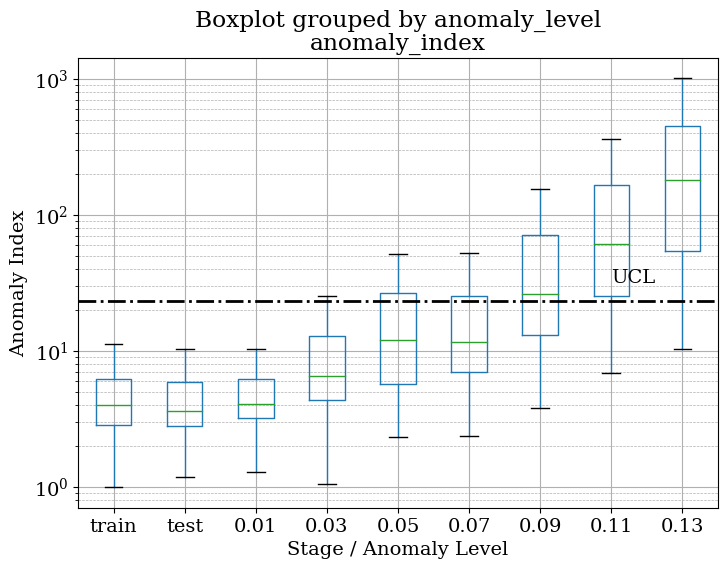

In [115]:
axs['System_0'].get_figure()


In [118]:
aucs['System_10']

,anomaly_level,anomaly_index
0,0.01,0.539
1,0.03,0.756
2,0.05,0.938
3,0.07,0.986
4,0.09,0.994
5,0.11,0.999
6,0.13,1.000


In [42]:
# lets see the impact of the window size on the auc 
windows_list = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28]
auc_list = []
for window in windows_list:
    df_sys = select_system(df_res, 5)
    df_sys = order_df(df_sys)
    if window != 0:
        df_sys = average_window(df_sys,window=window)
    df_sys_n = scale_anomaly_index(df_sys)
    auc = get_auc_per_level(df_sys_n.dropna())
    auc_list.append(auc.iloc[1]['anomaly_index'])


Text(0, 0.5, 'AUC')

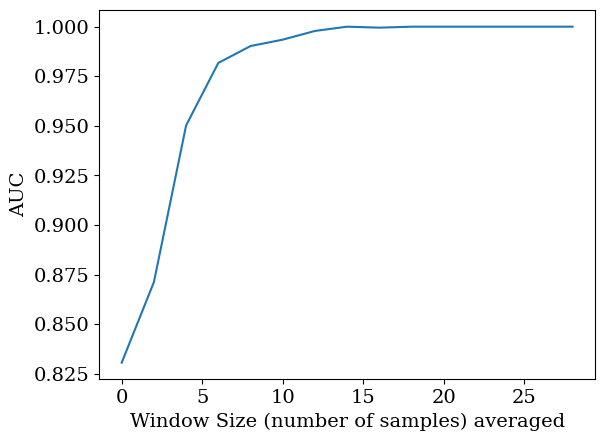

In [44]:
plt.plot(windows_list, auc_list)
plt.xlabel('Window Size (number of samples) averaged' )
plt.ylabel('AUC')